In [1]:
import numpy as np
from PIL import Image
import os
import sys
import time
hspath = os.path.abspath('./HWS/')
if hspath not in sys.path:
    sys.path.append(hspath)

from HS_Image import *
from HS_Centroids import *
from HS_Gradients import *
from HS_WFP  import *
import HSM_WFN
import matplotlib.pylab as plt
import matplotlib


In [2]:
# import HSM_Zernike to analyse HOA:
import HSM_Zernike
import importlib
importlib.reload(HSM_Zernike)

<module 'HSM_Zernike' from '/home/psales/Documents/MIT/LIGO/sams_shws/HWS/HSM_Zernike.py'>

In [3]:
## Recompute sphericla power using 1 set average:
data_dir = "./data/2019-11-26 18:24:33/"
#data_dir = "./data/191126/"
ref_str = '_ref'
sam_str = '_sam'
voltage_min = 0.0
voltage_max = 150.0
voltage_step = 10.0
pzv = np.linspace(voltage_min,voltage_max,(voltage_max-voltage_min)//voltage_step+1)
stv = [-590,-600,-612,-621,-633,-644,-657,-670,-681,-694,-708,-721,-734,-747,-762,-773]

data = []

crop = 512
#[1024-crop:1024+crop,1024-crop:1024+crop]

for v in pzv:
    v_str = str(v)
    ref = np.array(Image.open(data_dir + v_str + 'V' + ref_str + '.png'))
    ref = ref[1024-crop:1024+crop,1024-crop:1024+crop]
    ref = None
    sam = np.array(Image.open(data_dir + v_str + 'V' + sam_str + '.png'))
    sam = sam[1024-crop:1024+crop,1024-crop:1024+crop]
    #print(sam.max(),"  ",ref.max())
    print(v)
    data.append([ref,sam])

0.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
110.0
120.0
130.0
140.0
150.0


In [4]:
#origin = array([1024.0,1024.0])#array([534.69596094, 511.1660639 ])
origin = array([512.0,512.0])
#origin = array([256.0,256.0])

In [13]:
matplotlib.rcParams['figure.figsize'] = [16, 16]

scp = []
data_proc = []
for i in range(len(data)):
    hsi_ref = HS_Image()
    hsi_ref.original_image = data[0][1]
    hsi_ref.background = 0
    hsi_ref.process_image()
    #plt.figure(1)
    #plt.imshow(hsi_ref.modified_image)
    #hsi_ref.modified_image = np.log10(hsi_ref.modified_image + 2)
    #plt.figure(2)
    #plt.imshow(hsi_ref.modified_image)
    #plt.show()
    hsc_ref = HS_Centroids()
    hsc_ref.hsimage = hsi_ref
    hsc_ref.radius = 10
    hsc_ref.find_centroids()
    
    hsi_live = HS_Image()
    hsi_live.original_image = data[i][1]
    hsi_live.background = 0
    hsi_live.process_image()
    #hsi_live.modified_image = np.log10(hsi_live.modified_image + 2)
    hsc_live = HS_Centroids()
    hsc_live.hsimage = hsi_live
    hsc_live.radius = 10
    hsc_live.find_centroids_using_template(hsc_ref.centroids)
    hsg_raw = HS_Gradients(hsc_ref, hsc_live)
    hsg_raw.lever_arm = 4.1e-3
    hsg_raw.magnification = 1/0.71
    hsg_raw.pixel_size = 2*5.86e-6
    hsg_raw.construct_gradients()
    grad_notilt = hsg_raw.gradients[:,:2]-np.mean(hsg_raw.gradients[:,:2],axis=0)
    hsc_live1 = HS_Centroids()
    hsc_live1.centroids = hsc_ref.centroids + grad_notilt*(hsg_raw.lever_arm*hsg_raw.magnification/(hsg_raw.pixel_size))
    hsg = HS_Gradients(hsc_ref, hsc_live1)
    hsg.pixel_size = hsg_raw.pixel_size
    hsg.magnification = hsg_raw.magnification
    hsg.lever_arm = hsg_raw.lever_arm
    hsg.construct_gradients()
    hsg.origin = origin
    hsg.construct_gradients()
    # Find  spherical power using fitting polynomial:
    hswfp = HS_WFP(hsg)
    #w1 = (hsc_ref.intensities/np.max(hsc_ref.intensities))
    #w = np.vstack((w1,w1)).transpose()
    hswfp.compute_poly_coeffs()
    hswfp.compute_seidel_coeffs()
    sp = hswfp.seidel_coeffs['spherical_power']
    cp = hswfp.seidel_coeffs['cylindrical_power']
    ph = hswfp.seidel_coeffs['phi']
    scp.append((sp,cp,ph))
    print(pzv[i],' ', np.shape(hsc_ref.centroids))
    #plt.scatter(hsc_ref.centroids[:,0],hsc_ref.centroids[:,1])
    #plt.scatter(hsc_live.centroids[:,0],hsc_live.centroids[:,1])
    #plt.show()

0.0   (470, 2)
10.0   (470, 2)
20.0   (470, 2)
30.0   (470, 2)
40.0   (470, 2)
50.0   (470, 2)
60.0   (470, 2)
70.0   (470, 2)
80.0   (470, 2)
90.0   (470, 2)
100.0   (470, 2)
110.0   (470, 2)
120.0   (470, 2)
130.0   (470, 2)
140.0   (470, 2)
150.0   (470, 2)


In [14]:
sp = np.array(scp)[:,0]

pzv_fit = np.polyfit(pzv,sp,2)
pzv_func = np.poly1d(pzv_fit)
vrange = np.linspace(0,150,100)
PV_fit = pzv_func(vrange)

stv_fit = np.polyfit(stv,sp,1)
stv_func = np.poly1d(stv_fit)
srange = np.linspace(min(stv),max(stv),10)
SV_fit = stv_func(srange)

In [15]:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

Text(0, 0.5, 'Defocus [mD]')

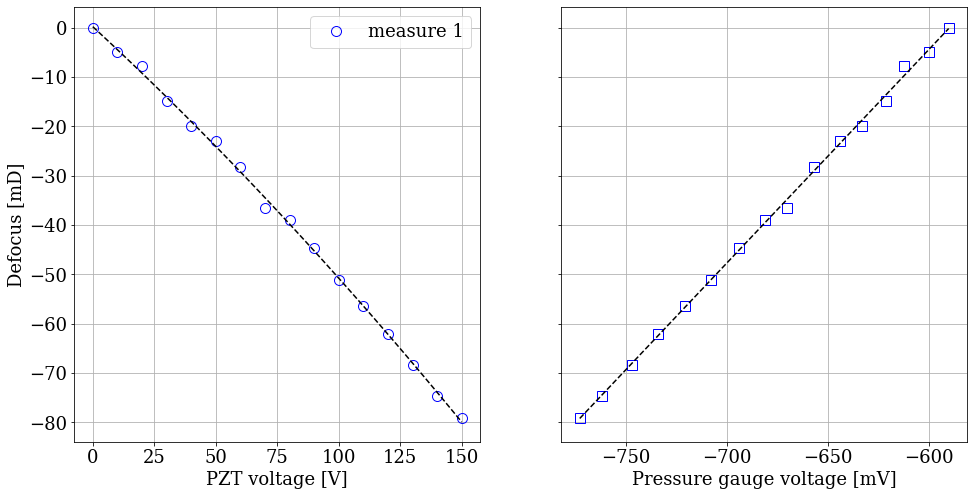

In [16]:
# Plot spherical power and input voltage  + pressure gauge voltage:
fig, axs = plt.subplots(1,2,figsize=(16,8),sharey=True)
axs[0].plot(pzv,1e3*sp,'ob',ms=10,mfc='none',label='measure 1')
axs[0].plot(vrange,1e3*PV_fit,'--k',ms=10,mfc='none')

axs[1].plot(stv,1e3*sp,'sb',ms=10,mfc='none')
axs[1].plot(srange,1e3*SV_fit,'--k',ms=10,mfc='none')
#axs[1].text(-300,-10,r'S={p0}V$_o$+{p1}'.format(p0=np.around(1e3*stv_fit[0],2),p1=np.around(1e3*stv_fit[1],2) ))

axs[0].legend()
axs[0].grid(which='both')
axs[1].grid(which='both')
axs[0].set_xlabel('PZT voltage [V]')
axs[1].set_xlabel('Pressure gauge voltage [mV]')
axs[0].set_ylabel('Defocus [mD]')


-0.07775726448834203 [-0.02185822295598516, -0.021625286785231915, -0.03808674382573826, -0.05272688824841695, -0.06370435972486317, -0.07775726448834203, -0.00927146717747835, -0.021017106543491294, -0.036260181841803546, -0.05049117178964192, -0.0634827027859539, -0.07710070727576206]


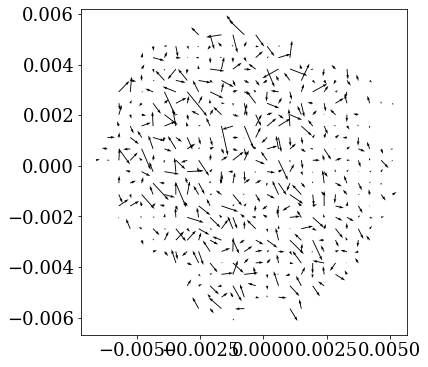

In [9]:
file_name ='V150_u0/live_0.tif'
file = Image.open(data_dir+file_name)
live = np.array(file)[:,:,0]
hsi_live = HS_Image()
hsi_live.original_image = live
hsi_live.background = 0
hsi_live.process_image()
#hsi_live.modified_image = np.log10(hsi_live.modified_image + 2)
hsc_live = HS_Centroids()
hsc_live.hsimage = hsi_live
hsc_live.radius = 10
hsc_live.find_centroids_using_template(hsc_ref0.centroids)
hsg_raw = HS_Gradients(hsc_ref0, hsc_live)
hsg_raw.lever_arm = 4.1e-3
hsg_raw.magnification = 1/0.71
hsg_raw.pixel_size = 2*5.86e-6
hsg_raw.construct_gradients()
grad_notilt = hsg_raw.gradients[:,:2]-np.mean(hsg_raw.gradients[:,:2],axis=0)
hsc_live1 = HS_Centroids()
hsc_live1.centroids = hsc_ref0.centroids + grad_notilt*(hsg_raw.lever_arm*hsg_raw.magnification/(hsg_raw.pixel_size))
hsg = HS_Gradients(hsc_ref0, hsc_live1)
hsg.pixel_size = hsg_raw.pixel_size
hsg.magnification = hsg_raw.magnification
hsg.lever_arm = hsg_raw.lever_arm
hsg.origin = origin
hsg.construct_gradients()
hswfp = HS_WFP(hsg)
hswfp.compute_poly_coeffs()
hswfp.compute_seidel_coeffs()
cents = hsg.gradients[:,2:]
Sgrads = -hswfp.seidel_coeffs['spherical_power']*cents
resgrads = hsg.gradients[:,:2]-Sgrads
plt.figure(figsize=(10,6))
plt.quiver(hsg.gradients[:,2],hsg.gradients[:,3],resgrads[:,0],resgrads[:,1])
plt.gca().set_aspect('equal')
print(hswfp.seidel_coeffs['spherical_power'], Su)

In [10]:
## Using Zernike to evaluateboth defocus and higher order abberation:
iorder =  50
ratio = 1
Rmax = np.min([abs(hsg.gradients[:,2].min()),hsg.gradients[:,2].max(),abs(hsg.gradients[:,3].min()),hsg.gradients[:,3].max()]) # Radius of circular pupil over which Zernikecoeffs are evaulated
bcoeff = HSM_Zernike.compute_Zernike_from_hsg(hsg,iorder,R0=ratio*Rmax)

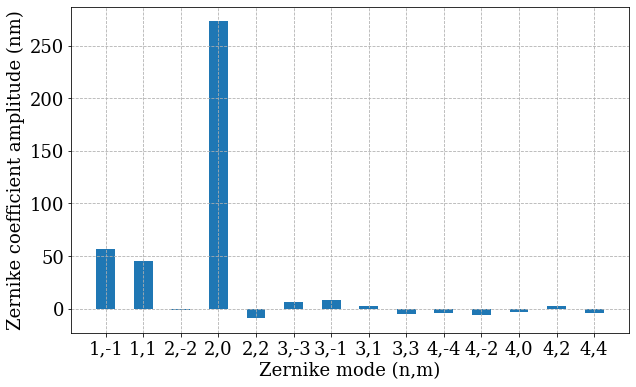

In [11]:
HSM_Zernike.bar_plot_zernike(bcoeff, i=None, logplot = False)

In [15]:
x = np.linspace(-1,1,300)
y = np.linspace(-1,1,300)
X,Y = np.meshgrid(x,y)
R,PHI = HSM_Zernike.cart2pol(X,Y)
wfZ = HSM_Zernike.construct_wf(R,PHI, bcoeff)
wfZ[X**2+Y**2>1]=np.nan
wfZ -= np.nan_to_num(wfZ).max()

# Find  centroid of the region:
from scipy.ndimage.measurements import center_of_mass as com
com_wf = np.rint(com(np.nan_to_num(wfZ))).astype(int) # centroid given in term of idex
# centroi in term of X,Y
xcent = Rmax*ratio*X[com_wf[0],com_wf[1]] # given in term of metric unit
ycent = Rmax*ratio*Y[com_wf[0],com_wf[1]]  # given in term of metric unit
# Reconstruct the origin in pixel value in hsg_gradients using the new centroids
xcent_p = xcent/(hsg.magnification*hsg.pixel_size)
ycent_p = ycent/(hsg.magnification*hsg.pixel_size)
origin_new = origin+[xcent_p,ycent_p]
# Reset the origin so we analyse the center of deformation
hsg.origin = origin_new
hsg.construct_gradients()
Rmax = np.min([abs(hsg.gradients[:,2].min()),hsg.gradients[:,2].max(),abs(hsg.gradients[:,3].min()),hsg.gradients[:,3].max()]) # Radius of circular pupil over which Zernikecoeffs are evaulated
bcoeff = HSM_Zernike.compute_Zernike_from_hsg(hsg,iorder,R0=ratio*Rmax)

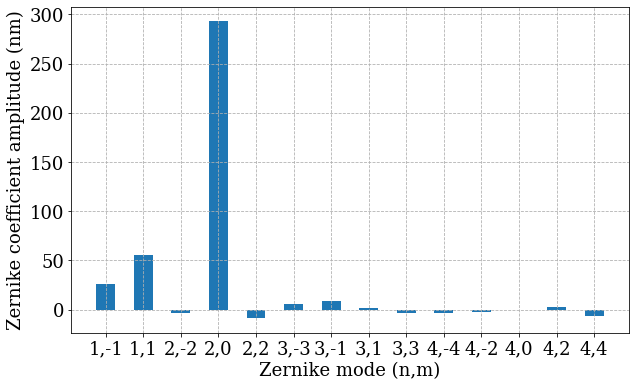

In [16]:
HSM_Zernike.bar_plot_zernike(bcoeff, i=None, logplot = False)

Defocus:  71.89610044970584  mD
Astigmatism: 0.9966896982358824  mD
Astigmatism angle: 122.73233272869504


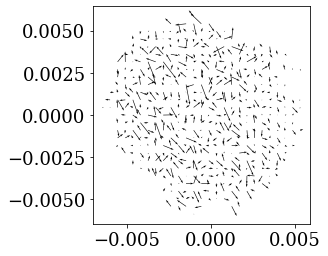

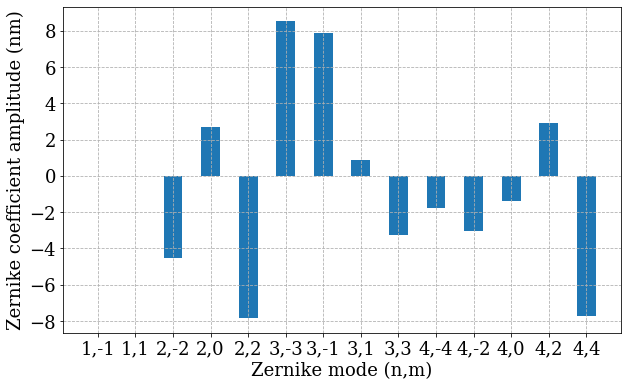

In [17]:
Rmax = np.min([abs(hsg.gradients[:,2].min()),hsg.gradients[:,2].max(),abs(hsg.gradients[:,3].min()),hsg.gradients[:,3].max()]) # Radius of circular pupil over which Zernikecoeffs are evaulated
W20 = 2*sqrt(3)*(bcoeff[3]) - 6*sqrt(5)*(bcoeff[11])-sqrt(sqrt(6)*bcoeff[2]**2+sqrt(6)*bcoeff[4]**2)
W22 = 2*sqrt(sqrt(6)*bcoeff[2]**2+sqrt(6)*bcoeff[4]**2)
W40 = 6*sqrt(5)*(bcoeff[11]) 
S = 2*W20/(ratio*Rmax)**2
As =  W22/(ratio*Rmax)**2
theta = np.rad2deg((np.arctan(bcoeff[4]/bcoeff[5])+np.pi)%(2*np.pi))
# Construct the axis of astigmatism
r1_x =  1*np.cos(np.deg2rad(theta)-np.pi)
r1_y =  1*np.sin(np.deg2rad(theta)-np.pi)
r2_x =  1*np.cos(np.deg2rad(theta))
r2_y =  1*np.sin(np.deg2rad(theta))
#Rs = 2/0.02
Rs = 2/S
print('Defocus: ',1e3*S,' mD')
print('Astigmatism:', 1e3*As,' mD')
print('Astigmatism angle:', theta)
# Costruct wavefront with reoval of spherical component 
cents = hsg.gradients[:,2:]
hsg_S = HSM_Zernike.construct_spherical_gradient(Rs, cents)

hsg_noS = HSM_Zernike.construct_residual_gradient(hsg, Rs)
bcoeff_noS = HSM_Zernike.compute_Zernike_from_hsg(hsg_noS,iorder,R0=ratio*Rmax)
plt.quiver(hsg.gradients[:,2], hsg.gradients[:,3], hsg.gradients[:,0]-hsg_S[:,0], hsg.gradients[:,1]- hsg_S[:,1])
plt.gca().set_aspect('equal')
bcoeff_noS[:2]=0
HSM_Zernike.bar_plot_zernike(bcoeff_noS, i=None, logplot = False)

In [18]:
# Numerically integrate full wavefront:
gspacing = Rmax*ratio*(x[1]-x[0])
cents = hsg.gradients[:,2:]
limits = {}
limits['x'] = array([-Rmax*ratio,Rmax*ratio])
limits['y'] = array([-Rmax*ratio,Rmax*ratio])
wfn = HSM_WFN.calculate_wf(hsg.gradients[:,2:],hsg.gradients[:,:2],limits, gspacing)
wfn[X**2+Y**2>1]=np.nan
wfn -= np.min((np.nan_to_num(wfn))[np.nonzero(np.nan_to_num(wfn))])
wfn -= np.nan_to_num(wfn).mean()


In [19]:
# Numerically integrated wavefront after defocus removal:
#hsg_noS.gradients[:,:2] -=  np.mean(hsg_noS.gradients[:,:2],axis=0)
wfn_noS = HSM_WFN.calculate_wf(hsg_noS.gradients[:,2:],hsg_noS.gradients[:,:2],limits, gspacing)
wfn_noS[X**2+Y**2>1]=np.nan
wfn_noS -= np.min((np.nan_to_num(wfn_noS))[np.nonzero(np.nan_to_num(wfn_noS))])
wfn_noS -= np.nan_to_num(wfn_noS).mean()

In [20]:
# Numerically integrated removing all quadratic compoenet:
poly_coeffs = zeros(shape(hswfp.poly_coeffs_array))
poly_coeffs[0:5] = hswfp.poly_coeffs_array[0:5] # remove all quadratic component
gradients_quad = hswfp.calculate_gradients(poly_coeffs)
gradients_noquad = hsg.gradients[:,0:2] - gradients_quad
wfn_noquad = HSM_WFN.calculate_wf(hsg.gradients[:,2:],gradients_noquad,limits, gspacing)
wfn_noquad[X**2+Y**2>1]=np.nan
wfn_noquad -= np.min((np.nan_to_num(wfn_noquad))[np.nonzero(np.nan_to_num(wfn_noquad))])
wfn_noquad -= np.nan_to_num(wfn_noquad).mean()

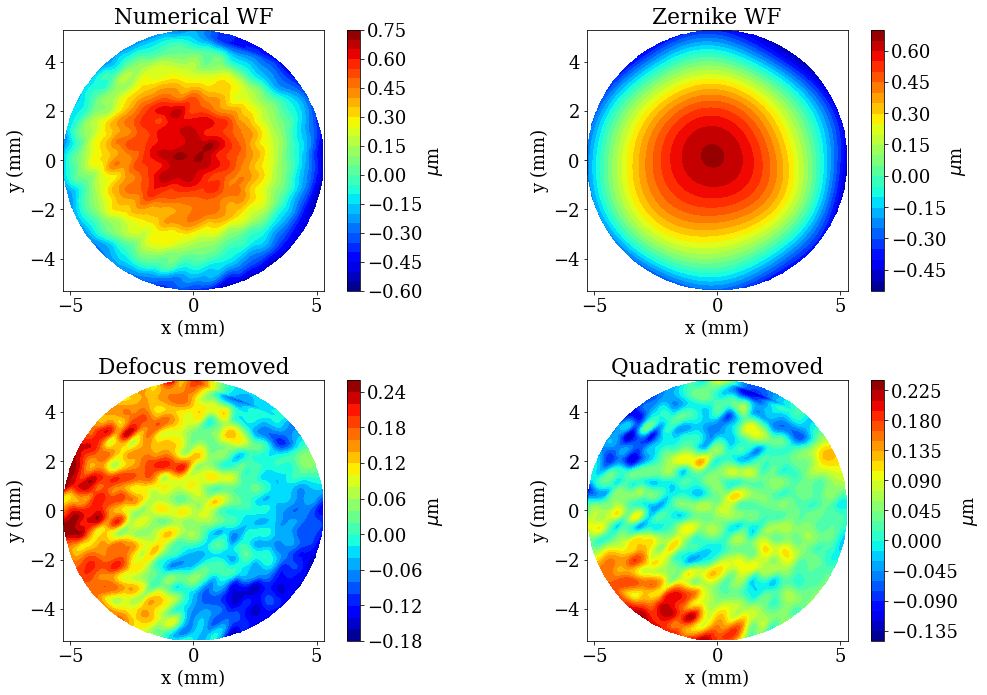

In [26]:
wfZ = HSM_Zernike.construct_wf(R,PHI, bcoeff)
wfZ_noS = HSM_Zernike.construct_wf(R,PHI, bcoeff_noS)
wfZ[X**2+Y**2>1]=np.nan
wfZ -= np.nan_to_num(wfZ).max()
wfZ = np.abs(wfZ) 
wfZ -= np.nan_to_num(wfZ).mean()
wfZ_noS[X**2+Y**2>1]=np.nan
wfZ_noS -= np.nan_to_num(wfZ_noS).max()
wfZ_noS = np.abs(wfZ_noS)
wfZ_noS -= np.nan_to_num(wfZ_noS).mean()

fig, axs = plt.subplots(2,2,figsize=(15,10))
pl1=axs[0,1].contourf(1e3*Rmax*ratio*X,1e3*Rmax*ratio*Y, 1e6*wfZ,25, cmap='jet')
cb1=plt.colorbar(pl1,ax=axs[0,1])
pl2=axs[1,0].contourf(1e3*Rmax*ratio*X,1e3*Rmax*ratio*Y, 1e6*wfn_noS,25, cmap='jet')
cb2=plt.colorbar(pl2,ax=axs[1,0])
pl3 = axs[0,0].contourf(1e3*Rmax*ratio*X,1e3*Rmax*ratio*Y, 1e6*wfn,25, cmap='jet')
cb3=plt.colorbar(pl3,ax=axs[0,0])
pl4 = axs[1,1].contourf(1e3*Rmax*ratio*X,1e3*Rmax*ratio*Y, 1e6*wfn_noquad,25, cmap='jet')
cb4=plt.colorbar(pl4,ax=axs[1,1])
cb1.set_label(r'$\mu$m')
cb2.set_label(r'$\mu$m')
cb3.set_label(r'$\mu$m')
cb4.set_label(r'$\mu$m')

axs[0,0].set_aspect('equal')
axs[0,0].set_xlabel('x (mm)')
axs[0,1].set_ylabel('y (mm)')
axs[0,0].set_ylabel('y (mm)')
axs[1,0].set_ylabel('y (mm)')
axs[1,0].set_xlabel('x (mm)')
axs[0,1].set_aspect('equal')
axs[0,1].set_xlabel('x (mm)')
axs[0,1].set_ylabel('y (mm)')
axs[1,0].set_aspect('equal')
axs[1,1].set_aspect('equal')
axs[1,1].set_xlabel('x (mm)')
axs[1,1].set_ylabel('y (mm)')
axs[0,0].set_title('Numerical WF')
axs[0,1].set_title('Zernike WF')
axs[1,0].set_title('Defocus removed')
axs[1,1].set_title('Quadratic removed')
plt.tight_layout()
plt.savefig('WF_150Vu_0.pdf')

In [27]:
from pykat import BeamParam
from pykat.optics.gaussian_beams import HG_mode
from pykat.optics.knm import riemann_HG_knm, makeCouplingMatrix, plot_knm_matrix
from pykat.optics.maps import curvedmap
from collections import defaultdict

ModuleNotFoundError: No module named 'pykat'

In [ ]:
# Since astigmatism is low, we compute higher order mode scattering only:
px = gspacing
N = np.shape(wfn_noS)[0]
x = np.arange(-N/2, N/2)*px
def gauss_amp(A, wx, wy, Rcx, Rcy, dx,dy):
    qx = BeamParam(rc=Rcx, w=wx)
    qy = BeamParam(rc=Rcy, w=wy)
    hg = HG_mode(qx, qy)
    #E  = A*rebin(hg.Unm(x-dx*px,x-dy*px), (512,512))
    E  = A*hg.Unm(x-dx*px,x-dy*px)
    return E
lambd = 1064e-9
k = 2*np.pi/lambd
w = 1e-3*np.arange(0.1,2,0.1)
HOMS = []
for iw in w:
    E0 = gauss_amp(1,iw,iw, 1e99, 1e99, 0, 0)
    E0[X**2+Y**2>1]=np.nan
    Erefl = np.nan_to_num(E0)*np.exp(1j*k*np.nan_to_num(wfn_noS))
    I0 = np.sum(np.nan_to_num(E0)*np.conjugate(Erefl)*px**2)
    I1 = np.sum(np.conjugate(np.nan_to_num(E0))*(Erefl)*px**2)
    I2 = np.sum(np.nan_to_num(E0)*np.conjugate(np.nan_to_num(E0))*px**2)
    HOMS.append((1-((I0*I1)/I2))*100 )# express in percentage


In [ ]:
plt.figure(figsize=(10,6))
plt.plot(1e3*w,np.real(HOMS),'b')
plt.grid(which='both')
plt.xlabel('Beam radius (mm)')
plt.ylabel('High order mode scattering (%)')
plt.tight_layout()

In [ ]:
qx = BeamParam(rc=1e99, w=iw)
qy = BeamParam(rc=1e99, w=iw)
C = makeCouplingMatrix(10)[0]
HGs = np.zeros( C.shape[0], dtype=complex)
for i,_ in enumerate(C):
    mode_in = _[:2]
    mode_out = _[2:]
    HGs[i]= riemann_HG_knm(x[::1], x[::1], mode_in, mode_out, qx, qx, qy, qy, Erefl)

## Using Zernike to quantify all defocus for all measuremnt:

In [25]:
iorder = 50
ratio = 1
Su_Z = [] 
Asu_Z = []
Sd_Z = [] 
Asd_Z = []
thetu_Z = []
thetd_Z = []
HOMS_u = []
HOMS_d = []
w = 1e-3*np.arange(0.1,2,0.1)

for iS in sets:
    # setting referenc
    if iS == 0:
        hsc_ref = hsc_ref0
    elif iS == 1:
        hsc_ref = hsc_ref1
    for iP in path:
        if iP == 'u':
            V_file=Vu_file
        else:
            V_file=Vd_file
        for ifile in range(0+iS,len(V_file),2):
            file = Image.open(ref_dir+V_file[ifile])
            live = np.array(file)[:,:,0]
            hsi_live = HS_Image()
            hsi_live.original_image = live
            hsi_live.background = 0
            hsi_live.process_image()
            hsc_live = HS_Centroids()
            hsc_live.hsimage = hsi_live
            hsc_live.radius = 10
            hsc_live.find_centroids_using_template(hsc_ref.centroids)
            hsg_raw = HS_Gradients(hsc_ref, hsc_live)
            hsg_raw.lever_arm = 4.1e-3
            hsg_raw.magnification = 1/0.71
            hsg_raw.pixel_size = 2*5.86e-6
            hsg_raw.construct_gradients()
            grad_notilt = hsg_raw.gradients[:,:2]-np.mean(hsg_raw.gradients[:,:2],axis=0)
            hsc_live1 = HS_Centroids()
            hsc_live1.centroids = hsc_ref.centroids + grad_notilt*(hsg_raw.lever_arm*hsg_raw.magnification/(hsg_raw.pixel_size))
            hsg = HS_Gradients(hsc_ref, hsc_live1)
            hsg.pixel_size = hsg_raw.pixel_size
            hsg.magnification = hsg_raw.magnification
            hsg.lever_arm = hsg_raw.lever_arm
            hsg.construct_gradients()
            mag=np.sqrt(np.sum(hsg.gradients[:,:2]**2,axis=1))
            hsg.origin = origin_new # Adjust the origin to put the deformation at the center
            hsg.construct_gradients()
            # Find  spherical power using fitting polynomial:
            hswfp = HS_WFP(hsg)
            bcoeff = HSM_Zernike.compute_Zernike_from_hsg(hsg,iorder,R0=ratio*Rmax)
            # Compute defocus  and astigmatism:
            W20 = 2*sqrt(3)*(bcoeff[3]) - 6*sqrt(5)*(bcoeff[11])-sqrt(sqrt(6)*bcoeff[2]**2+sqrt(6)*bcoeff[4]**2)
            W22 = 2*sqrt(sqrt(6)*bcoeff[2]**2+sqrt(6)*bcoeff[4]**2)
            #W40 = 6*sqrt(5)*(bcoeff[11]) 
            S = 2*W20/(ratio*Rmax)**2
            As =  W22/(ratio*Rmax)**2
            theta = np.rad2deg((np.arctan(bcoeff[4]/bcoeff[5])+np.pi)%(2*np.pi))
            # Compute  the residual wavefront with no S
            Rs = 2/S
            hsg_noS = HSM_Zernike.construct_residual_gradient(hsg, Rs)
            wfn_noS = HSM_WFN.calculate_wf(hsg_noS.gradients[:,2:],hsg_noS.gradients[:,:2],limits, gspacing)
            wfn_noS[X**2+Y**2>1]=np.nan
            wfn_noS -= np.min((np.nan_to_num(wfn_noS))[np.nonzero(np.nan_to_num(wfn_noS))])
            wfn_noS -= np.nan_to_num(wfn_noS).mean()
            
            # Compute higher order scattering
            HOMS = []
            for iw in w:
                E0 = gauss_amp(1,iw,iw, 1e99, 1e99, 0, 0)
                E0[X**2+Y**2>1]=np.nan
                Erefl = np.nan_to_num(E0)*np.exp(1j*k*np.nan_to_num(wfn_noS))
                I0 = np.sum(np.nan_to_num(E0)*np.conjugate(Erefl)*px**2)
                I1 = np.sum(np.conjugate(np.nan_to_num(E0))*(Erefl)*px**2)
                I2 = np.sum(np.nan_to_num(E0)*np.conjugate(np.nan_to_num(E0))*px**2)
                HOMS.append((1-((I0*I1)/I2))*100 )
            HOMS = np.transpose(HOMS)
            if iP == 'u':
                Su_Z.append(S)
                Asu_Z.append(As)
                thetu_Z.append(theta)
                HOMS_u.append(HOMS )
            else:
                Sd_Z.append(S)
                Asd_Z.append(As)
                thetd_Z.append(theta)
                HOMS_d.append(HOMS)
                
            print(V_file[ifile])

FileNotFoundError: [Errno 2] No such file or directory: './data/20191111_1/ref/V25_u0/live_0.tif'

In [24]:
Sd_Z  = np.array(Sd_Z)
Sd_Z1 = Sd_Z.copy()
Sd_Z1[6:] -= Sd_Z1[6:].min()
Su_Z1 = np.array(Su_Z)
Su_Z1 = np.concatenate((Su_Z1,[Sd_Z1[0],Sd1[6]]))
zu = np.polyfit(np.concatenate((Vu_all,[0,0])), Su_Z1, 2)
pu= np.poly1d(zu)
V_fit = np.linspace(0,150,200)
Su_fit = pu(V_fit)

Sd_Z2 = np.concatenate((Sd_Z1,[Su_Z[5],Su_Z[11]]))
zd = np.polyfit(np.concatenate((Vd_all,[150,150])), Sd_Z2, 2)
pd= np.poly1d(zd)
Sd_fit = pd(V_fit)

Sall = np.concatenate((np.array(Su_Z),np.array(Sd_Z1)))
Pall = np.concatenate((np.array(Pu),np.array(Pd)))
zP = np.polyfit(Pall, Sall, 1)
pP= np.poly1d(zP)
VP_fit = np.linspace(Pall.min(), Pall.max(),100)
SP_fit = pP(VP_fit)

NameError: name 'Sd_Z' is not defined

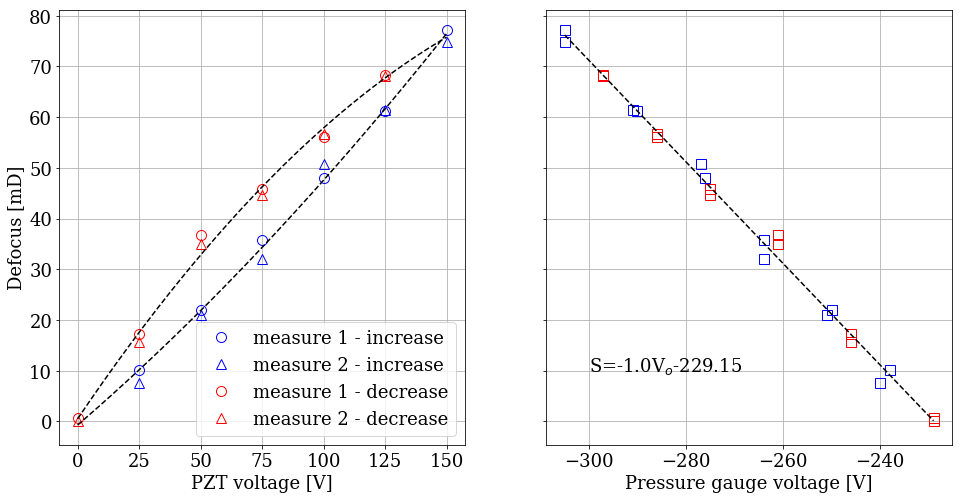

In [132]:
fig, axs = plt.subplots(1,2,figsize=(16,8),sharey=True)


axs[0].plot(Vu_all[:6],1e3*np.array(Su_Z)[:6],'ob',ms=10,mfc='none',label='measure 1 - increase')
axs[0].plot(Vu_all[6:],1e3*np.array(Su_Z)[6:],'^b',ms=10,mfc='none',label='measure 2 - increase')
axs[0].plot(Vd_all[:6],1e3*np.array(Sd_Z)[:6],'or',ms=10,mfc='none',label='measure 1 - decrease')
axs[0].plot(Vd_all[6:],1e3*np.array(Sd_Z1)[6:],'^r',ms=10,mfc='none',label='measure 2 - decrease')
axs[1].plot(Pu,1e3*np.array(Su_Z),'sb',ms=10,mfc='none')
axs[1].plot(Pd,1e3*np.array(Sd_Z1),'sr',ms=10,mfc='none')
axs[0].plot(V_fit,1e3*Su_fit,'--k',ms=10,mfc='none')
axs[0].plot(V_fit,1e3*Sd_fit,'--k',ms=10,mfc='none')
axs[1].plot(VP_fit,1e3*SP_fit,'--k',ms=10,mfc='none')

axs[1].text(-300,10,r'S={p0}V$_o${p1}'.format(p0=np.around(1e3*zP[0],2),p1=np.around(1e3*zP[1],2) ))

axs[0].legend()
axs[0].grid(which='both')
axs[1].grid(which='both')
axs[0].set_xlabel('PZT voltage [V]')
axs[1].set_xlabel('Pressure gauge voltage [V]')
axs[0].set_ylabel('Defocus [mD]')
plt.savefig('PZT_Actuation_range.pdf')

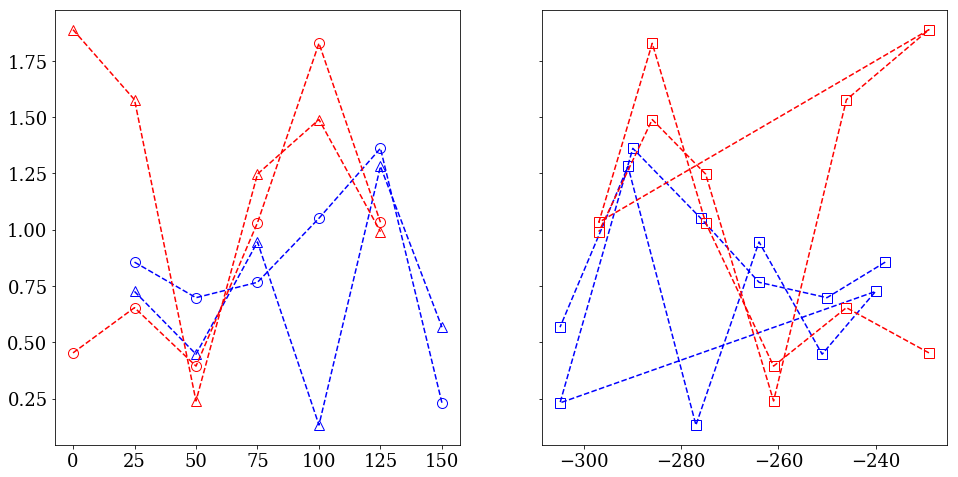

In [115]:
fig, axs = plt.subplots(1,2,figsize=(16,8),sharey=True)
axs[0].plot(Vu_all[:6],1e3*np.array(Asu_Z)[:6],'o--b',ms=10,mfc='none',label='measure 1 - increase')
axs[0].plot(Vu_all[6:],1e3*np.array(Asu_Z)[6:],'^--b',ms=10,mfc='none',label='measure 2 - increase')
axs[0].plot(Vd_all[:6],1e3*np.array(Asd_Z)[:6],'o--r',ms=10,mfc='none',label='measure 1 - decrease')
axs[0].plot(Vd_all[6:],1e3*np.array(Asd_Z)[6:],'^--r',ms=10,mfc='none',label='measure 2 - decrease')
axs[1].plot(Pu,1e3*np.array(Asu_Z),'sb--',ms=10,mfc='none')
axs[1].plot(Pd,1e3*np.array(Asd_Z),'sr--',ms=10,mfc='none')

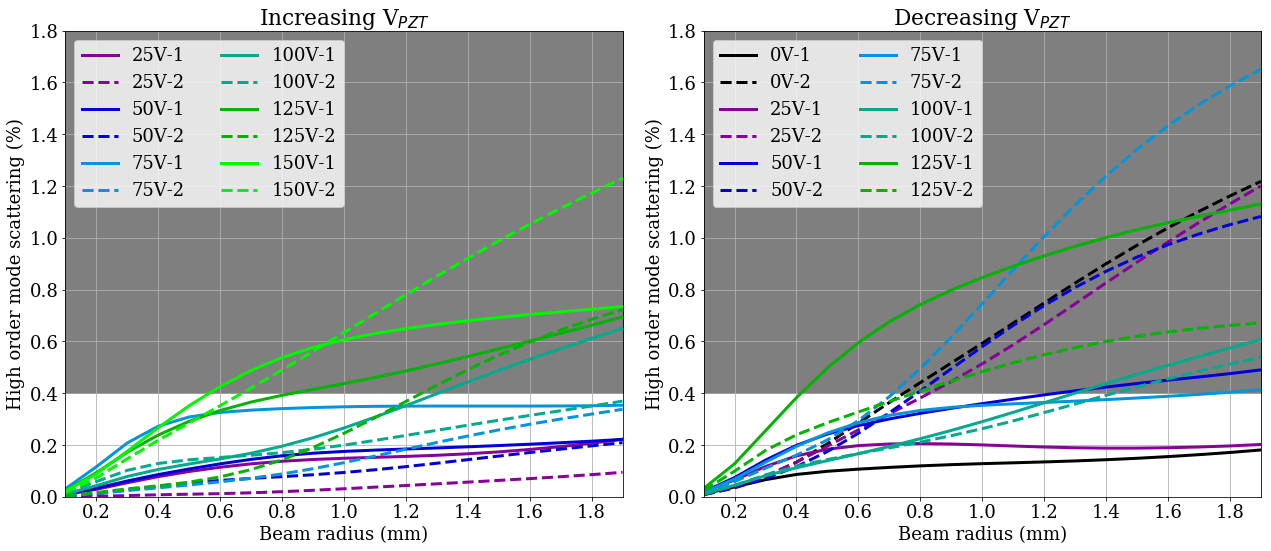

In [156]:
# Plotting highe order mode scattering:
x = np.linspace(np.min(1e3*w),np.max(1e3*w),10)
y = 0.4*np.ones(len(x))
fig, axs = plt.subplots(1,2, figsize =(18,8))
nlines = np.shape(Vu_all[:6])[0]
color_idx = np.linspace(0.2, 1, nlines)
for i,_ in enumerate(Vu_all[:6]):
    axs[0].plot(1e3*w,np.real(HOMS_u[i]),linewidth=3, color=plt.cm.nipy_spectral(_),label='{iV}V-1'.format(iV=_))
    axs[0].plot(1e3*w,np.real(HOMS_u[6+i]),'--',linewidth=3, color=plt.cm.nipy_spectral(_),label='{iV}V-2'.format(iV=_))
axs[0].legend(ncol=2)
axs[0].grid(which='both')
for i,_ in enumerate(Vd_all[:6]):
    axs[1].plot(1e3*w,np.real(HOMS_d[i]),linewidth=3, color=plt.cm.nipy_spectral(_),label='{iV}V-1'.format(iV=_))
    axs[1].plot(1e3*w,np.real(HOMS_d[6+i]),'--',linewidth=3, color=plt.cm.nipy_spectral(_),label='{iV}V-2'.format(iV=_))
axs[1].fill_between(x, y, y2=1.8,color='k',alpha=0.5)
axs[0].fill_between(x, y, y2=1.8,color='k',alpha=0.5)

axs[1].legend(ncol=2)
axs[1].grid(which='both')
axs[1].set_xlabel('Beam radius (mm)')
axs[0].set_xlabel('Beam radius (mm)')
axs[1].set_title(r'Decreasing V$_{PZT}$')
axs[0].set_title(r'Increasing V$_{PZT}$')
axs[0].set_ylabel('High order mode scattering (%)')
axs[1].set_ylabel('High order mode scattering (%)')
axs[0].set_xlim([np.min(1e3*w),np.max(1e3*w)])
axs[1].set_xlim([np.min(1e3*w),np.max(1e3*w)])
axs[0].set_ylim([0,1.8])
axs[1].set_ylim([0,1.8])
plt.tight_layout()
plt.savefig('Higher_order_mode_scattering.pdf')

In [103]:
shape(HOMS_u)[1]

19